# Diplomatura en Ciencias de Datos, Aprendizaje Automático y sus Aplicaciones - Introducción al aprendizaje supervisado
# Laboratorio 2: Armado de un esquema de aprendizaje automático
Autores: Matías Oria, Antonela Sambuceti, Pamela Pairo, Benjamín Ocampo

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import plot_tree

## Carga de datos y división en entrenamiento y evaluación

La celda siguiente se encarga de la carga de datos (haciendo uso de pandas).

In [2]:
dataset = pd.read_csv("./data/loan_data.csv", comment="#")
seed = 0

# División entre instancias y etiquetas
X, y = dataset.iloc[:, 1:], dataset.TARGET

scaler = StandardScaler()
X = scaler.fit_transform(X)

# división entre entrenamiento y evaluación
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=seed)

In [3]:
(X_train.shape, X_test.shape)

((1483, 10), (371, 10))

In [4]:
dataset

,TARGET,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,0,4700,88026.0,115506.0,6.0,0.0,0.0,182.248332,0.0,27.0,29.209023
1,0,19300,39926.0,101208.0,4.0,0.0,0.0,140.051638,0.0,14.0,31.545694
2,0,5700,71556.0,79538.0,2.0,0.0,0.0,92.643085,0.0,15.0,41.210012
3,0,13000,44875.0,57713.0,0.0,1.0,0.0,184.990324,1.0,12.0,28.602076
4,0,19300,72752.0,106084.0,11.0,0.0,0.0,193.707100,1.0,13.0,30.686106
...,...,...,...,...,...,...,...,...,...,...,...
1849,1,53400,228236.0,305514.0,6.0,0.0,0.0,11.148069,0.0,2.0,34.558417
1850,1,53600,235895.0,299772.0,5.0,0.0,0.0,112.748282,7.0,22.0,44.945929
1851,1,53600,208197.0,297280.0,4.0,1.0,1.0,160.485251,2.0,29.0,41.646731
1852,1,65500,205156.0,290239.0,2.0,0.0,0.0,98.808206,1.0,21.0,144.189001



Documentación:

- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

## Ejercicio 1: Descripción de los Datos y la Tarea

### 1. ¿De qué se trata el conjunto de datos?

El *dataset* contiene un conjunto de datos que describen el comportamiento
crediticio histórico de los clientes de un banco, que hayan solicitado
préstamos recientemente.

### 2. ¿Cuál es la variable objetivo que hay que predecir? ¿Qué significado tiene?

La variable objetivo `TARGET` es una variable binaria que asume
el valor 1, si el cliente no pagó el credito solicitado, y 0 para el caso
contrario.

### 3. ¿Qué información (atributos) hay disponible para hacer la predicción?

- LOAN: Monto del préstamo requerido.
- MORTDUE: Saldo del crédito hipotecario existente.
- VALUE: Valor actual de la propiedad.
- YOJ: Años en el trabajo actual.
- DEROG: Número de informes despectivos.
- DELINQ: Número de créditos en estado moroso.
- CLAGE: Linea de crédito más antigua medida en meses.
- NINQ: Número reciente de lineas de crédito.
- CLNO: Número de lineas de crédito.
- DEBTINC: Cociente entre deuda e ingresos.

### 4. ¿Qué atributos imagina ud. que son los más determinantes para la predicción?

Creemos que el monto del préstamo `LOAN`, el comportamiento del cliente,
medido tanto en el número de informes despectivos `DEROG`como en su morosidad
`DELINQ` pueden influir en esta predicción. También el estado actual de su
deuda comparado con sus ingresos podría importar en esta predicción `DEBTINC`.

### Análisis de la variable `TARGET`

In [5]:
dataset["TARGET"].value_counts()
nof_targets_train = len(y_train)
nof_ones_train = np.sum(y_train == 1)
nof_zeros_train = np.sum(y_train == 0)

nof_targets_test = len(y_test)
nof_ones_test = np.sum(y_test == 1)
nof_zeros_test = np.sum(y_test == 0)

(nof_ones_train / nof_targets_train, nof_ones_test / nof_targets_test)

(0.16925151719487525, 0.15633423180592992)

Observamos que tanto en el conjunto de entrenamiento como en el conjunto que
usaremos para validar nuestra predicción, la variable Target se encuentra
desbalanceada. Tan solo un 16% de los casos pertenecen a la clase 1 que
significa que el cliente no pagó el préstamo.

Antes de continuar creemos conveniente dejar acentadas algunas definiciones
que nos servirán a la hora de evaluar nuestros modelos predictivos:

- 0 (Clase negativa): Pagó el prestamo.
- 1 (Clase positiva): No pagó el prestamo.
- TP: Casos predichos que no pagarón y no pagaron efectivamente.
- TF: Casos predichos que pagaron y pagaron efectivamente.
- FP: Casos predichos que P (No pagó el prestamo) y pasó N (Pagó el prestamo).
- FN: Casos predichos que N (Pagó el prestamo) y pasó P (No pagó el prestamo).

- Recall: $\frac{TP}{TP + FN}$
- Precisión: $\frac{TP}{TP + FP}$
- F1-score : $2\times(\frac{Precision \times Recall}{Precision + Recall})$

Teniendo en cuenta lo anteriormente mencionado, preferimos aquellos modelos
con mayor Recall que predigan de la mejor forma la clase positiva, es decir
aquellos casos que no pagarán el préstamo. Es decir, preferimos tener menos
falsos negativos (casos predichos como que pagarán el préstamo, pero en
realidad no pagaron el préstamo), evitando así pérdidas para el banco, a costa
de perder algunas ventas teniendo más falsos positivos (casos predichos como
que no iban a pagar el préstamo y en realidad sí lo hicieron).

## Ejercicio 2: Predicción con Modelos Lineales

En este ejercicio se entrenarán modelos lineales de clasificación para
predecir la variable objetivo.

Para ello, se utilizará la clase SGDClassifier de scikit-learn.

Documentación:
- https://scikit-learn.org/stable/modules/sgd.html
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html


### Ejercicio 2.1: SGDClassifier con hiperparámetros por defecto

En primer lugar, entrenaremos y evaluaremos el clasificador SGDClassifier
usando los valores por omisión de scikit-learn para todos los parámetros.

#### Entrenamiento

In [6]:
clf = SGDClassifier(random_state=seed)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [7]:
y_pred

array([0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,

#### Evaluación y matríz de confusión

In [8]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.95      0.92       313
           1       0.57      0.40      0.47        58

    accuracy                           0.86       371
   macro avg       0.73      0.67      0.69       371
weighted avg       0.84      0.86      0.85       371



Observamos que se logran valores superiores al 0.86 es todas las
medidas con este modelo (utilizaremos el weighted avg ya que en este caso
quermeos darle importancia a la clase minoritaria, es decir la clase 1 que
responde a los casos que no pagaron el préstamo)

In [9]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
(tn, fp, fn, tp)

(296, 17, 35, 23)

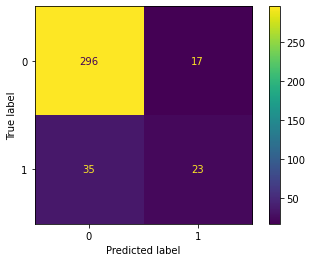

In [10]:
plot_confusion_matrix(clf, X_test, y_test)

In [11]:
clf.coef_.shape

(1, 10)

Existen solo 35 casos predichos como que iban a pagar el préstamo (clase 0)
pero en realidad no lo hicieron.

### Ejercicio 2.2: Ajuste de Hiperparámetros

A continuación seleccionaremos valores para los hiperparámetros principales
del SGDClassifier, y usaremos grid-search y 5-fold cross-validation sobre el
conjunto de entrenamiento para explorar muchas combinaciones posibles de
valores.

Documentación:
- https://scikit-learn.org/stable/modules/grid_search.html
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

#### Entrenamiento

In [12]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning, ConvergenceWarning

# Some parameters lead to a model which never predicts a class, so precision
# gets division by zero when it's calculated by means of its formula. It can be
# solved when calculating the metric but nothing can be done during grid search
# cv abstraction.
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# Same problem but with the maximum number of iterations. In this case, the
# algorithm stops early and we're informed with a warning.
warnings.filterwarnings("ignore", category=ConvergenceWarning)

param_grid = {
    'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
    'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1],
    'penalty': ['l2', 'l1'],
    'eta0': [1e-3, 1e-4, 1e-5, 10],
    'learning_rate': ['optimal', 'constant', 'adaptive'],
}

model = SGDClassifier(random_state=seed)
cv = GridSearchCV(model,
                  param_grid,
                  scoring=["recall", "accuracy", "precision", "f1"],
                  cv=5,
                  refit=False)
cv.fit(X_train, y_train)

results = cv.cv_results_
params = results['params']

In [13]:
results_df = pd.DataFrame(results)
results_df.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_alpha', 'param_eta0', 'param_learning_rate', 'param_loss',
       'param_penalty', 'params', 'split0_test_recall', 'split1_test_recall',
       'split2_test_recall', 'split3_test_recall', 'split4_test_recall',
       'mean_test_recall', 'std_test_recall', 'rank_test_recall',
       'split0_test_accuracy', 'split1_test_accuracy', 'split2_test_accuracy',
       'split3_test_accuracy', 'split4_test_accuracy', 'mean_test_accuracy',
       'std_test_accuracy', 'rank_test_accuracy', 'split0_test_precision',
       'split1_test_precision', 'split2_test_precision',
       'split3_test_precision', 'split4_test_precision', 'mean_test_precision',
       'std_test_precision', 'rank_test_precision', 'split0_test_f1',
       'split1_test_f1', 'split2_test_f1', 'split3_test_f1', 'split4_test_f1',
       'mean_test_f1', 'std_test_f1', 'rank_test_f1'],
      dtype='object')

In [14]:
relevant_metrics = [
    "mean_test_recall", "std_test_recall", "mean_test_accuracy",
    "std_test_accuracy", "mean_test_precision", "std_test_precision",
    'mean_test_f1', "rank_test_recall", 'rank_test_precision',
    'rank_test_accuracy', 'rank_test_f1'
]

params = ["param_alpha", "param_loss", "param_penalty", 'param_eta0']

results_df = results_df[relevant_metrics + params]
results_df

,mean_test_recall,std_test_recall,mean_test_accuracy,std_test_accuracy,mean_test_precision,std_test_precision,mean_test_f1,rank_test_recall,rank_test_precision,rank_test_accuracy,rank_test_f1,param_alpha,param_loss,param_penalty,param_eta0
0,0.414431,0.074592,0.833479,0.025451,0.568875,0.187708,0.456685,105,407,417,50,0.00001,hinge,l2,0.001
1,0.497882,0.111752,0.828692,0.023464,0.510390,0.063662,0.491526,18,453,525,8,0.00001,hinge,l1,0.001
2,0.410118,0.075988,0.809844,0.044030,0.466366,0.142812,0.425740,116,495,581,145,0.00001,log,l2,0.001
3,0.341882,0.149839,0.808449,0.057284,0.547560,0.246195,0.363242,189,418,592,446,0.00001,log,l1,0.001
4,0.362824,0.078359,0.826736,0.026032,0.486050,0.094490,0.414515,159,472,531,200,0.00001,modified_huber,l2,0.001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,0.000000,0.000000,0.830749,0.001259,0.000000,0.000000,0.000000,639,639,440,639,1,modified_huber,l1,10
716,0.131608,0.021017,0.850983,0.004792,0.919444,0.068268,0.229581,601,22,365,576,1,squared_hinge,l2,10
717,0.000000,0.000000,0.830749,0.001259,0.000000,0.000000,0.000000,639,639,440,639,1,squared_hinge,l1,10
718,0.601569,0.049090,0.791046,0.061270,0.446471,0.110724,0.503330,1,528,657,1,1,perceptron,l2,10


In [15]:
highest_rank = 1
results_df[results_df['rank_test_recall'] == highest_rank]

,mean_test_recall,std_test_recall,mean_test_accuracy,std_test_accuracy,mean_test_precision,std_test_precision,mean_test_f1,rank_test_recall,rank_test_precision,rank_test_accuracy,rank_test_f1,param_alpha,param_loss,param_penalty,param_eta0
718,0.601569,0.04909,0.791046,0.06127,0.446471,0.110724,0.50333,1,528,657,1,1,perceptron,l2,10


In [16]:
results_df[results_df['rank_test_precision'] == highest_rank]

,mean_test_recall,std_test_recall,mean_test_accuracy,std_test_accuracy,mean_test_precision,std_test_precision,mean_test_f1,rank_test_recall,rank_test_precision,rank_test_accuracy,rank_test_f1,param_alpha,param_loss,param_penalty,param_eta0
551,0.099686,0.018247,0.847609,0.003812,1.0,0.0,0.180798,621,1,387,597,0.1,hinge,l1,0.00001
561,0.099686,0.018247,0.847609,0.003812,1.0,0.0,0.180798,621,1,387,597,0.1,hinge,l1,0.00001
670,0.095765,0.020029,0.846936,0.004439,1.0,0.0,0.174170,623,1,389,599,1,hinge,l2,0.00001
680,0.095765,0.020029,0.846936,0.004439,1.0,0.0,0.174170,623,1,389,599,1,hinge,l2,0.00001


In [17]:
results_df[results_df['rank_test_f1'] == highest_rank]

,mean_test_recall,std_test_recall,mean_test_accuracy,std_test_accuracy,mean_test_precision,std_test_precision,mean_test_f1,rank_test_recall,rank_test_precision,rank_test_accuracy,rank_test_f1,param_alpha,param_loss,param_penalty,param_eta0
718,0.601569,0.04909,0.791046,0.06127,0.446471,0.110724,0.50333,1,528,657,1,1,perceptron,l2,10


In [18]:
results_df.loc[results_df['rank_test_recall'] == highest_rank, params]

,param_alpha,param_loss,param_penalty,param_eta0
718,1,perceptron,l2,10


#### Evaluación y matríz de confusión

In [19]:
clf_best = SGDClassifier(random_state=seed,
                         alpha=1,
                         loss="perceptron",
                         eta0=10,
                         penalty="l2")
clf_best.fit(X_train, y_train)
y_pred_best = clf_best.predict(X_test)

In [20]:
print(classification_report(y_test, y_pred_best))

              precision    recall  f1-score   support

           0       0.90      0.96      0.93       313
           1       0.65      0.41      0.51        58

    accuracy                           0.87       371
   macro avg       0.77      0.69      0.72       371
weighted avg       0.86      0.87      0.86       371



In [21]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("Anterior modelo", (tn, fp, fn, tp))

Anterior modelo (296, 17, 35, 23)


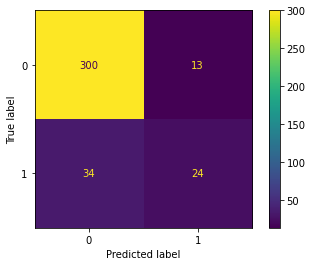

In [22]:
plot_confusion_matrix(clf_best, X_test, y_test)

Observamos que nuestros resultados son muy parecidos a los del
modelo entrenado en el apartado anterior, sin embargo mejoran todas las
predicciones.

## Ejercicio 3: Árboles de Decisión

En este ejercicio se entrenarán árboles de decisión para predecir la variable
objetivo.

Para ello, utilizaremos la clase DecisionTreeClassifier de scikit-learn.

Documentación:
- https://scikit-learn.org/stable/modules/tree.html
- https://scikit-learn.org/stable/modules/tree.html#tips-on-practical-use
- https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
- https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html

### Ejercicio 3.1: DecisionTreeClassifier con hiperparámetros por defecto

Entrenaremos y evaluaremos el clasificador DecisionTreeClassifier usando los
valores por omisión de scikit-learn para todos los parámetros.

In [23]:
# División entre instancias y etiquetas
X, y = dataset.iloc[:, 1:], dataset.TARGET

# división entre entrenamiento y evaluación
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=seed)

#### Entrenamiento

In [24]:
clf_tree = DecisionTreeClassifier(random_state=0)
clf_tree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=0)

#### Evaluación y gráfica del árbol

In [25]:
y_train_pred = clf_tree.predict(X_train)
y_test_pred = clf_tree.predict(X_test)

In [26]:
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)
print(f'Train accuracy: {train_acc:0.2}')
print(f'Test accuracy: {test_acc:0.2}')

Train accuracy: 1.0
Test accuracy: 0.88


In [27]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       313
           1       0.62      0.64      0.63        58

    accuracy                           0.88       371
   macro avg       0.77      0.78      0.78       371
weighted avg       0.88      0.88      0.88       371



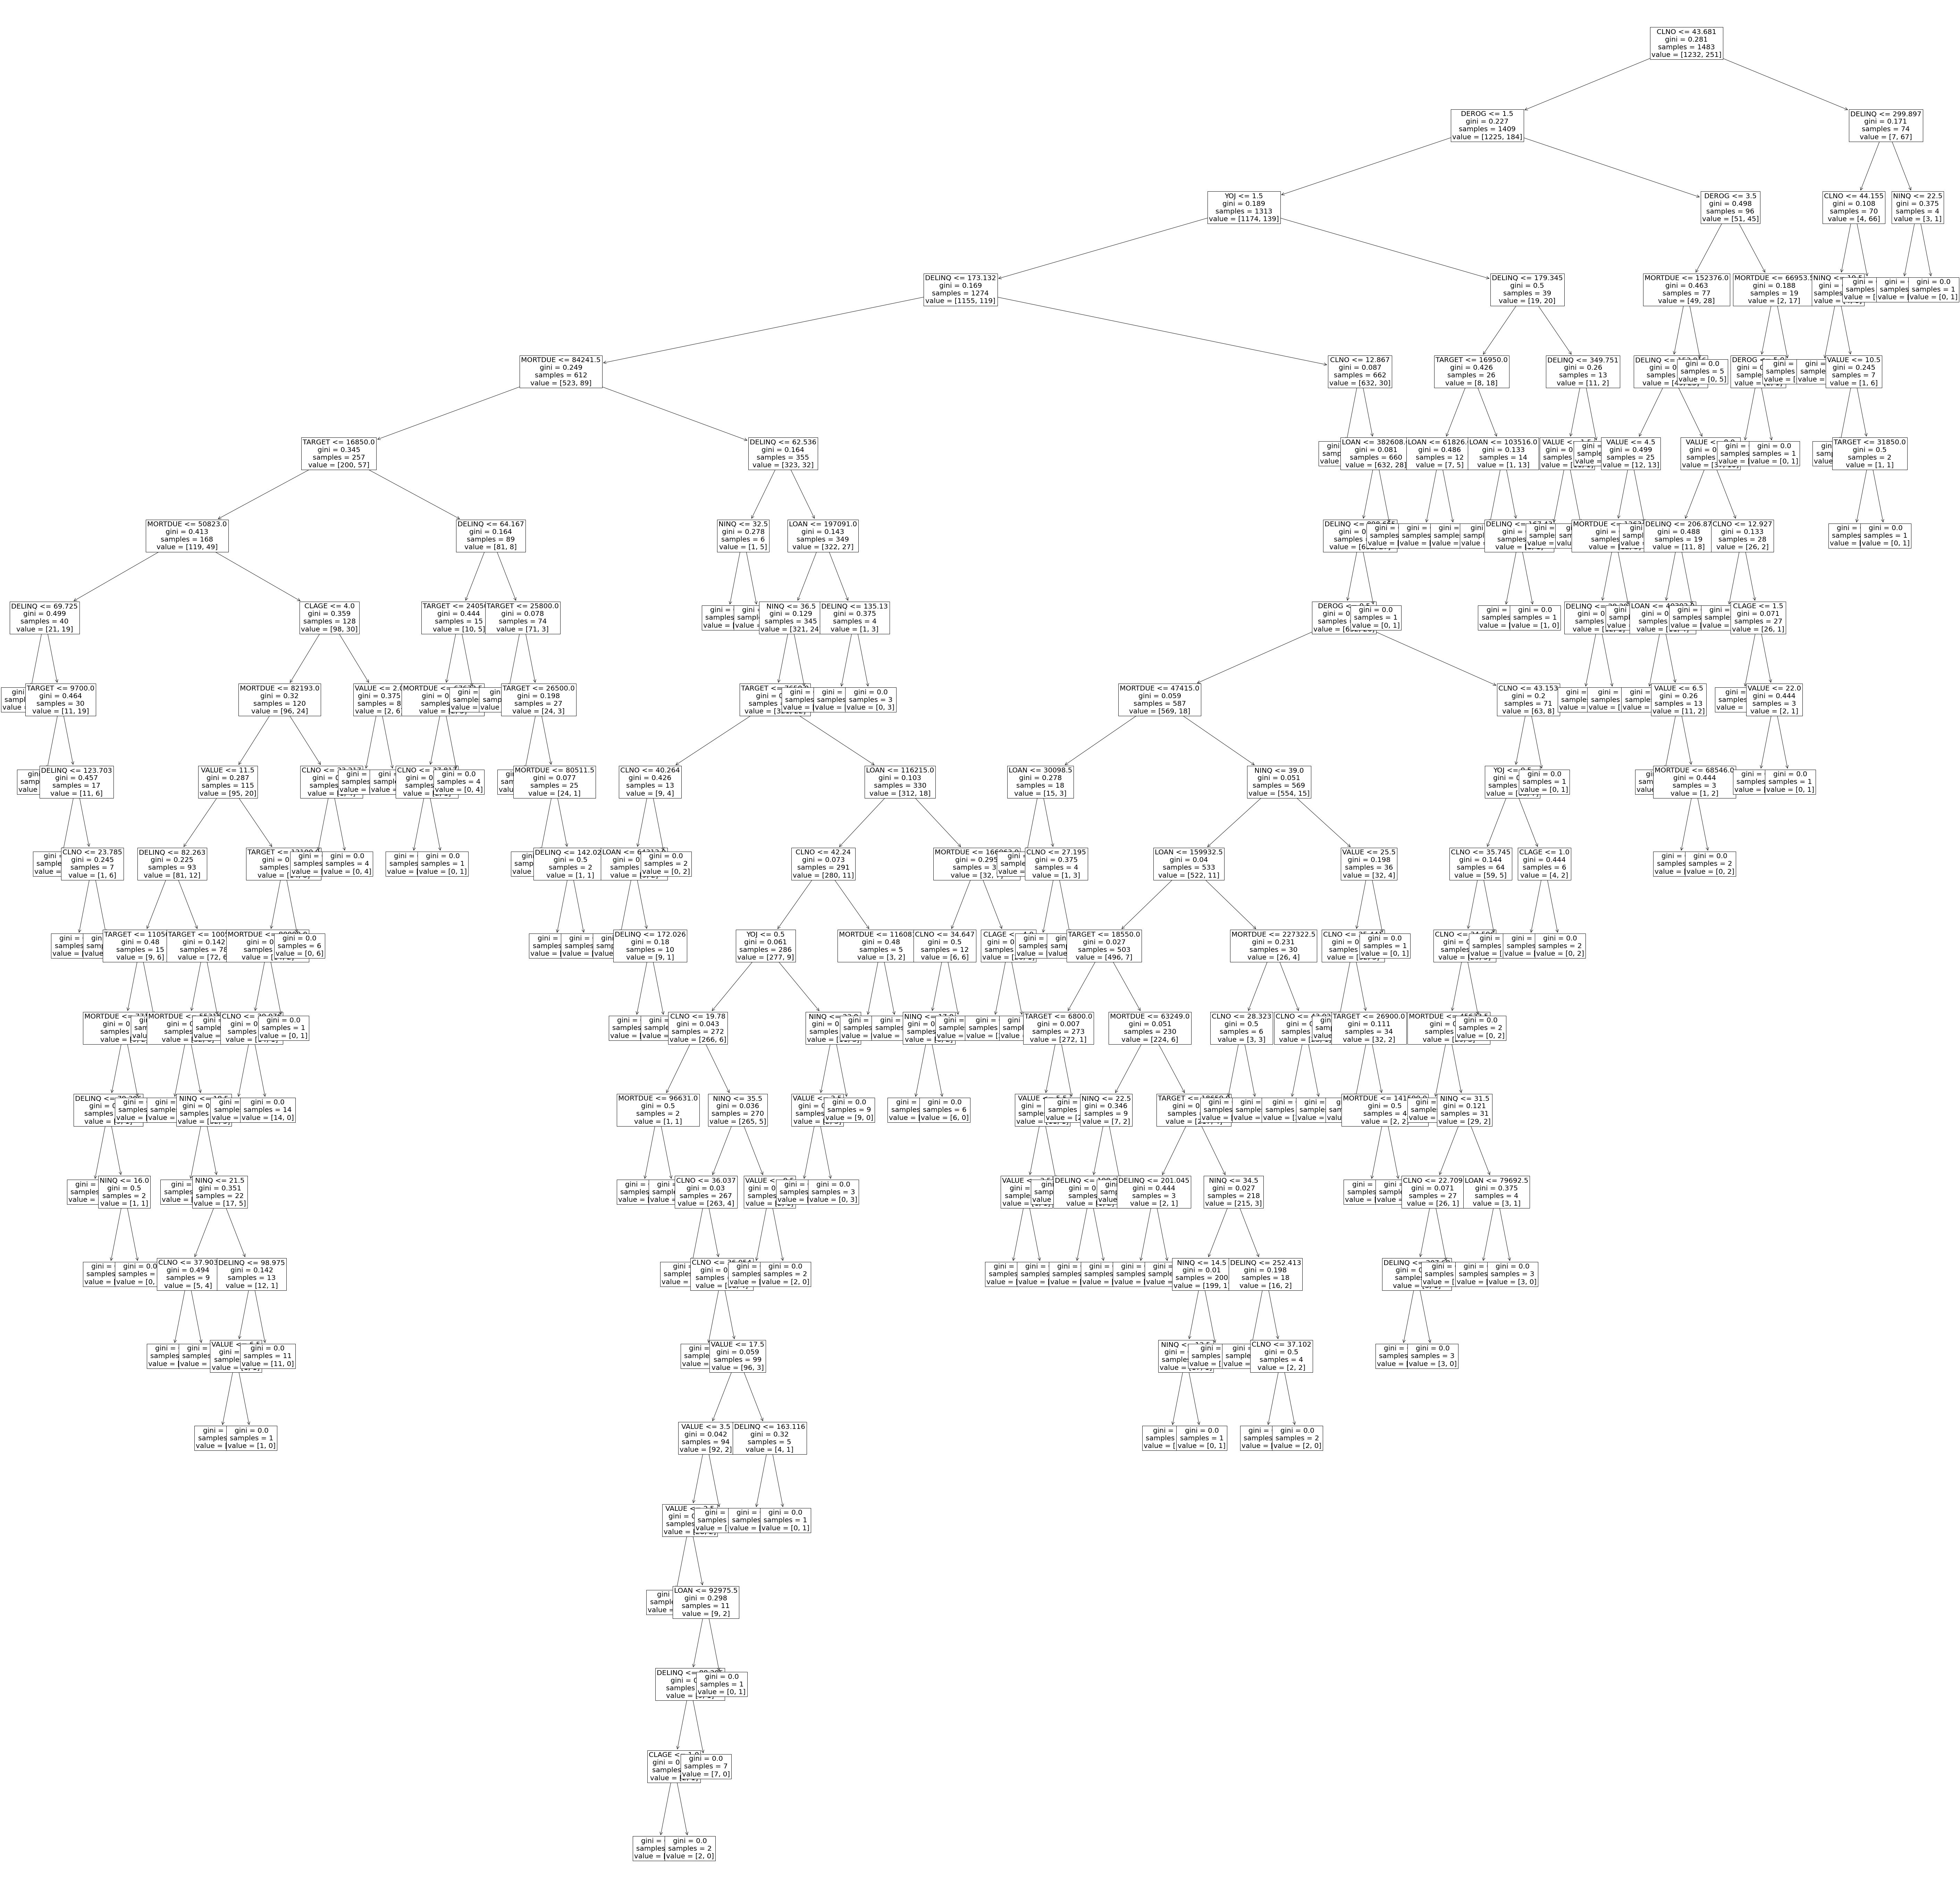

In [28]:
plt.figure(figsize=(100, 100))
plot_tree(clf_tree, fontsize=20, feature_names=dataset.columns)
plt.show()

Si bien los valores de las métricas son altos (todos los
promedios cercanos al 0.90) el árbol tiene una profundidad muy alta, perdiendo
interpretabilidad. A continuación probaremos con otros hiperparametros.

### Ejercicio 3.2: Ajuste de Hiperparámetros

Seleccionaremos algunos valores para los hiperparámetros del
DecisionTreeClassifier. Usaremos grid-search y 5-fold cross-validation sobre
el conjunto de entrenamiento para explorar muchas combinaciones posibles de
valores.

Documentación:
- https://scikit-learn.org/stable/modules/grid_search.html
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [29]:

param_grid = {
    'max_depth': [6, 7, 8, 9, 10],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [5, 10, 20, 30, 40, 50, 100],
    'min_samples_leaf': [5, 10, 20, 30, 40, 50]
}

model_tree = DecisionTreeClassifier(random_state=seed)
cv = GridSearchCV(model_tree,
                  param_grid,
                  scoring=["recall", "accuracy", "precision", "f1"],
                  cv=5,
                  refit=False)
cv.fit(X_train, y_train)

results_tree = cv.cv_results_
params_tree = results_tree['params']

In [30]:
results_df_tree = pd.DataFrame(results_tree)
results_df_tree.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_criterion', 'param_max_depth', 'param_min_samples_leaf',
       'param_min_samples_split', 'params', 'split0_test_recall',
       'split1_test_recall', 'split2_test_recall', 'split3_test_recall',
       'split4_test_recall', 'mean_test_recall', 'std_test_recall',
       'rank_test_recall', 'split0_test_accuracy', 'split1_test_accuracy',
       'split2_test_accuracy', 'split3_test_accuracy', 'split4_test_accuracy',
       'mean_test_accuracy', 'std_test_accuracy', 'rank_test_accuracy',
       'split0_test_precision', 'split1_test_precision',
       'split2_test_precision', 'split3_test_precision',
       'split4_test_precision', 'mean_test_precision', 'std_test_precision',
       'rank_test_precision', 'split0_test_f1', 'split1_test_f1',
       'split2_test_f1', 'split3_test_f1', 'split4_test_f1', 'mean_test_f1',
       'std_test_f1', 'rank_test_f1'],
      dtype='object')

In [31]:
relevant_metrics = [
    "mean_test_recall", "std_test_recall", "mean_test_accuracy",
    "std_test_accuracy", "mean_test_precision", "std_test_precision",
    'mean_test_f1', "rank_test_recall", 'rank_test_precision',
    'rank_test_accuracy', 'rank_test_f1'
]

params_tree = [
    'param_criterion', 'param_max_depth', 'param_min_samples_leaf',
    'param_min_samples_split'
]

results_df_tree = results_df_tree[relevant_metrics + params_tree]
results_df_tree

,mean_test_recall,std_test_recall,mean_test_accuracy,std_test_accuracy,mean_test_precision,std_test_precision,mean_test_f1,rank_test_recall,rank_test_precision,rank_test_accuracy,rank_test_f1,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split
0,0.410118,0.069384,0.875930,0.011531,0.740108,0.047258,0.524936,152,179,28,113,gini,6,5,5
1,0.410118,0.069384,0.875930,0.011531,0.740108,0.047258,0.524936,152,179,28,113,gini,6,5,10
2,0.422196,0.035030,0.875933,0.009069,0.731078,0.047610,0.534880,133,189,27,96,gini,6,5,20
3,0.406196,0.041005,0.877289,0.012604,0.770515,0.109080,0.528248,175,152,25,109,gini,6,5,30
4,0.410196,0.029931,0.872568,0.010818,0.733881,0.113536,0.521680,151,185,61,122,gini,6,5,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,0.278824,0.058979,0.867852,0.014537,0.845353,0.138419,0.414400,316,36,158,316,entropy,10,50,20
416,0.278824,0.058979,0.867852,0.014537,0.845353,0.138419,0.414400,316,36,158,316,entropy,10,50,30
417,0.278824,0.058979,0.867852,0.014537,0.845353,0.138419,0.414400,316,36,158,316,entropy,10,50,40
418,0.278824,0.058979,0.867852,0.014537,0.845353,0.138419,0.414400,316,36,158,316,entropy,10,50,50


In [32]:
highest_rank = 1
results_df_tree[results_df_tree['rank_test_recall'] == highest_rank]

,mean_test_recall,std_test_recall,mean_test_accuracy,std_test_accuracy,mean_test_precision,std_test_precision,mean_test_f1,rank_test_recall,rank_test_precision,rank_test_accuracy,rank_test_f1,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split
133,0.517647,0.053345,0.879985,0.015507,0.697551,0.069371,0.593083,1,225,9,6,gini,9,10,5
134,0.517647,0.053345,0.879985,0.015507,0.697551,0.069371,0.593083,1,225,9,6,gini,9,10,10
135,0.517647,0.053345,0.879985,0.015507,0.697551,0.069371,0.593083,1,225,9,6,gini,9,10,20


In [33]:
results_df_tree[results_df_tree['rank_test_precision'] == highest_rank]

,mean_test_recall,std_test_recall,mean_test_accuracy,std_test_accuracy,mean_test_precision,std_test_precision,mean_test_f1,rank_test_recall,rank_test_precision,rank_test_accuracy,rank_test_f1,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split
35,0.266824,0.063453,0.870546,0.011663,0.892844,0.07552,0.407529,381,1,78,351,gini,6,50,5
36,0.266824,0.063453,0.870546,0.011663,0.892844,0.07552,0.407529,381,1,78,351,gini,6,50,10
37,0.266824,0.063453,0.870546,0.011663,0.892844,0.07552,0.407529,381,1,78,351,gini,6,50,20
38,0.266824,0.063453,0.870546,0.011663,0.892844,0.07552,0.407529,381,1,78,351,gini,6,50,30
39,0.266824,0.063453,0.870546,0.011663,0.892844,0.07552,0.407529,381,1,78,351,gini,6,50,40
40,0.266824,0.063453,0.870546,0.011663,0.892844,0.07552,0.407529,381,1,78,351,gini,6,50,50
41,0.266824,0.063453,0.870546,0.011663,0.892844,0.07552,0.407529,381,1,78,351,gini,6,50,100
77,0.266824,0.063453,0.870546,0.011663,0.892844,0.07552,0.407529,381,1,78,351,gini,7,50,5
78,0.266824,0.063453,0.870546,0.011663,0.892844,0.07552,0.407529,381,1,78,351,gini,7,50,10
79,0.266824,0.063453,0.870546,0.011663,0.892844,0.07552,0.407529,381,1,78,351,gini,7,50,20


In [34]:
results_df_tree[results_df_tree['rank_test_f1'] == highest_rank]

,mean_test_recall,std_test_recall,mean_test_accuracy,std_test_accuracy,mean_test_precision,std_test_precision,mean_test_f1,rank_test_recall,rank_test_precision,rank_test_accuracy,rank_test_f1,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split
168,0.513569,0.062465,0.880669,0.020292,0.722342,0.121009,0.593551,10,194,7,1,gini,10,5,5
169,0.513569,0.062465,0.880669,0.020292,0.722342,0.121009,0.593551,10,194,7,1,gini,10,5,10


In [35]:
clf_best_tree = DecisionTreeClassifier(random_state=seed,
                                       criterion="gini",
                                       max_depth=9,
                                       min_samples_split=20,
                                       min_samples_leaf=10)
clf_best_tree.fit(X_train, y_train)
y_pred_best_tree = clf_best_tree.predict(X_test)

In [36]:
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_pred_best_tree)
print(f'Train accuracy: {train_acc:0.2}')
print(f'Test accuracy: {test_acc:0.2}')

Train accuracy: 1.0
Test accuracy: 0.9


In [37]:
print(classification_report(y_test, y_pred_best_tree))

              precision    recall  f1-score   support

           0       0.92      0.97      0.94       313
           1       0.77      0.52      0.62        58

    accuracy                           0.90       371
   macro avg       0.84      0.74      0.78       371
weighted avg       0.89      0.90      0.89       371



[Text(4755.755208333333, 5164.2, 'CLNO <= 43.681\ngini = 0.281\nsamples = 1483\nvalue = [1232, 251]'),
 Text(4138.177083333333, 4620.6, 'DEROG <= 1.5\ngini = 0.227\nsamples = 1409\nvalue = [1225, 184]'),
 Text(3419.6875, 4077.0, 'YOJ <= 1.5\ngini = 0.189\nsamples = 1313\nvalue = [1174, 139]'),
 Text(2499.375, 3533.3999999999996, 'DELINQ <= 173.132\ngini = 0.169\nsamples = 1274\nvalue = [1155, 119]'),
 Text(1459.5833333333333, 2989.7999999999997, 'MORTDUE <= 84241.5\ngini = 0.249\nsamples = 612\nvalue = [523, 89]'),
 Text(955.8333333333333, 2446.2, 'TARGET <= 16850.0\ngini = 0.345\nsamples = 257\nvalue = [200, 57]'),
 Text(568.3333333333333, 1902.6, 'MORTDUE <= 50823.0\ngini = 0.413\nsamples = 168\nvalue = [119, 49]'),
 Text(206.66666666666666, 1359.0, 'DELINQ <= 69.725\ngini = 0.499\nsamples = 40\nvalue = [21, 19]'),
 Text(103.33333333333333, 815.3999999999996, 'gini = 0.0\nsamples = 10\nvalue = [10, 0]'),
 Text(310.0, 815.3999999999996, 'TARGET <= 9700.0\ngini = 0.464\nsamples = 30\nv

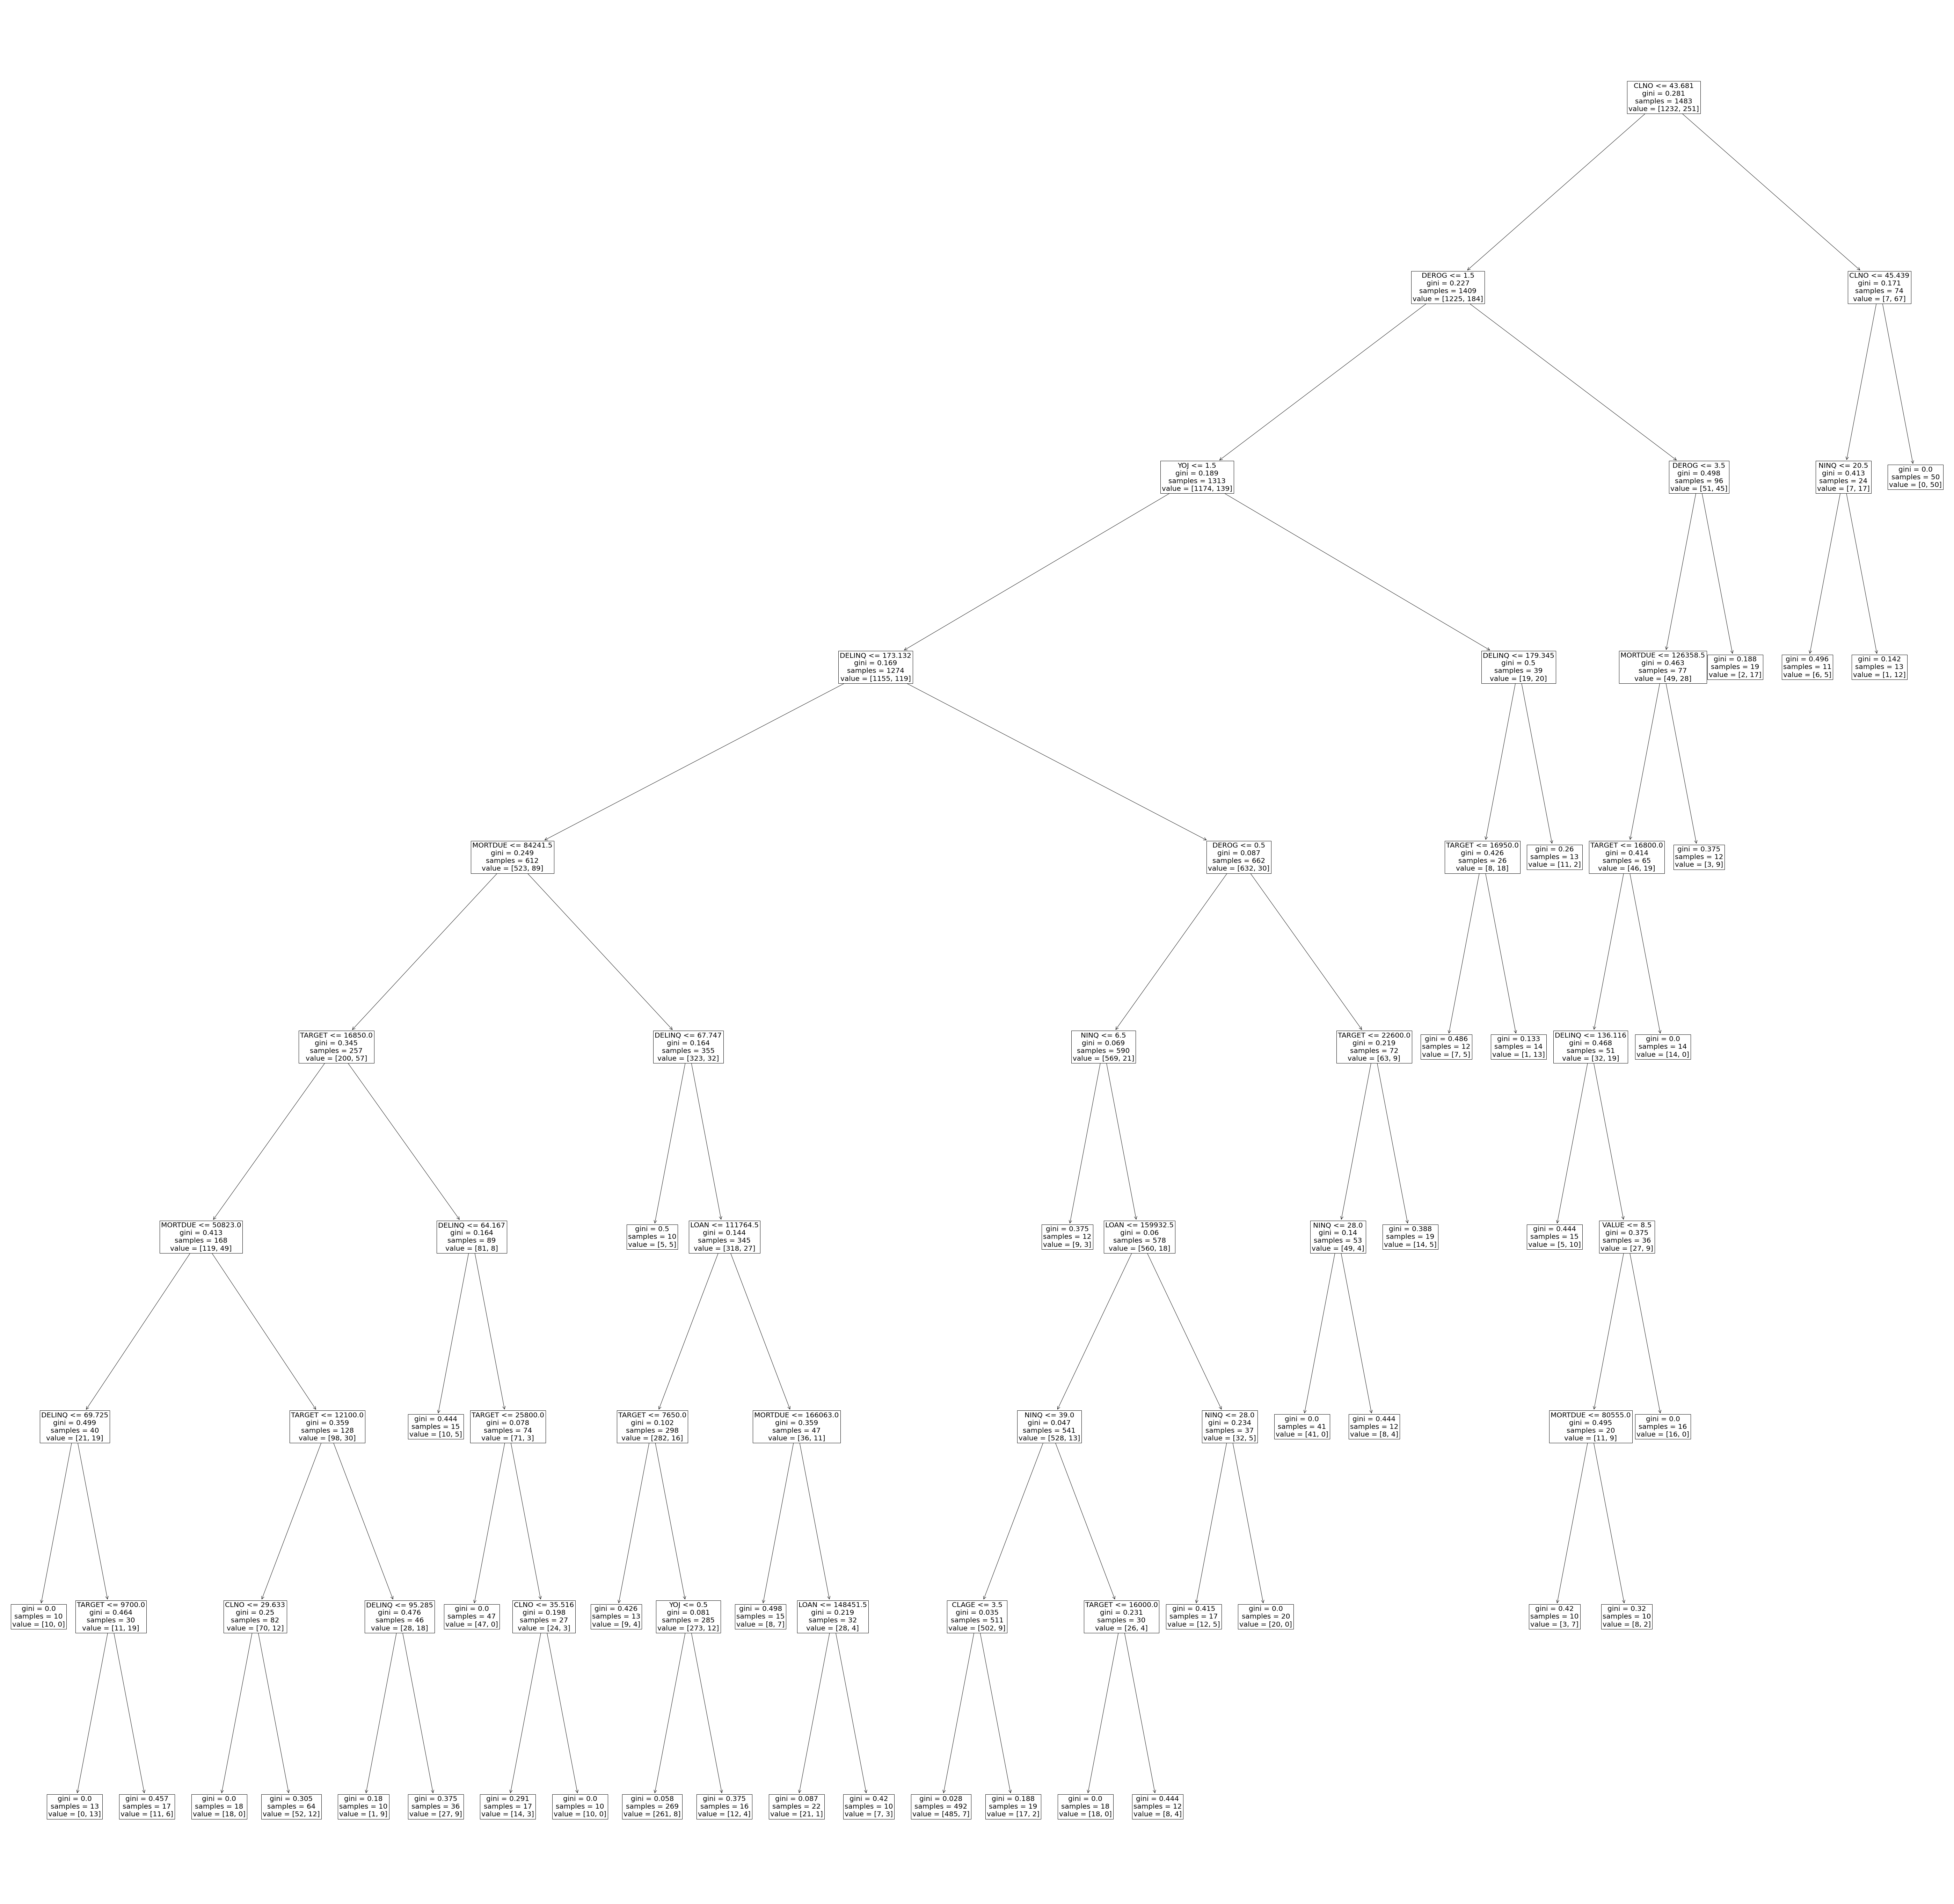

In [38]:
plt.figure(figsize=(100, 100))
plot_tree(clf_best_tree, fontsize=20, feature_names=dataset.columns)

Observamos que las medidas de nuestro predictor continuan
cercanas a al 0.90, mejorando notablemente la interpretabilidad del árbol, ya
que ahora tiene una menor profundidad.